In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Embedding,Input,Dense,Conv1D,MaxPooling1D,GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

In [13]:
embedding_size = 100
max_vocab_size = 20000
path = 'data/glove.6B.100d.txt'
max_sequence_length = 100
batch_size = 128
epochs = 10
validation_split = .2
filepath_model ="model_weights.hdf5"

In [3]:
def process_embedding_file(path):
    with open(path,encoding='utf-8') as f:
        word2vec = dict()
        for line in f:
            out = line.split()
            word = out[0]
            word2vec[word] = np.asarray(out[1:], dtype='float32')
        return word2vec
            
word2vec = process_embedding_file(path)
            

In [4]:
print('length of word embeddings : {}'.format(len(word2vec)))

length of word embeddings : 400000


In [6]:
df_train = pd.read_csv('data/train.csv')
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
#deleting records with null values
df_train.dropna(inplace=True)
sentences = df_train['comment_text'].values
target = df_train[labels].values

In [7]:
t = Tokenizer(num_words = max_vocab_size)
t.fit_on_texts(sentences)
sequences = t.texts_to_sequences(sentences)
word2idx = t.word_index
print('Number of unique words : {}'.format(len(word2idx)))
padded_sequences = pad_sequences(sequences,maxlen=max_sequence_length)

Number of unique words : 210337


In [8]:
# create weight matrix for words in training sentences
max_vocab_size = min(max_vocab_size,len(word2idx)+1)
embedding_matrix = np.zeros((max_vocab_size,embedding_size))
for word,index in word2idx.items():
    if index < max_vocab_size:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector


In [9]:
embedding_layer =Embedding(max_vocab_size,
                           embedding_size,
                           weights=[embedding_matrix],
                           input_length=max_sequence_length,
                           trainable=False)

In [10]:
#building model
input_model = Input(shape=(max_sequence_length,))
x = embedding_layer(input_model)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128,activation='relu')(x)
output = Dense(len(labels),activation='sigmoid')(x)

model =Model(input_model,output)
model.compile(loss = 'binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [11]:
#training model
checkpoint = ModelCheckpoint(filepath_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(padded_sequences,
                    target,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_split = validation_split,
                    callbacks=callbacks_list)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 144s 1ms/step - loss: 0.0833 - accuracy: 0.9733 - val_loss: 0.0712 - val_accuracy: 0.9762

Epoch 00001: val_accuracy improved from -inf to 0.97621, saving model to model_weights.hdf5
Epoch 2/10
127656/127656 [==============================] - 140s 1ms/step - loss: 0.0673 - accuracy: 0.9774 - val_loss: 0.0676 - val_accuracy: 0.9775

Epoch 00002: val_accuracy improved from 0.97621 to 0.97751, saving model to model_weights.hdf5
Epoch 3/10
127656/127656 [==============================] - 155s 1ms/step - loss: 0.0627 - accuracy: 0.9785 - val_loss: 0.0692 - val_accuracy: 0.9775

Epoch 00003: val_accuracy did not improve from 0.97751
Epoch 4/10
127656/127656 [==============================] - 140s 1ms/step - loss: 0.0593 - accuracy: 0.9793 - val_loss: 0.0985 - val_accuracy: 0.9659

Epoch 00004: val_accuracy did not improve from 0.97751
Epoch 5/10
127656/127656 [======================

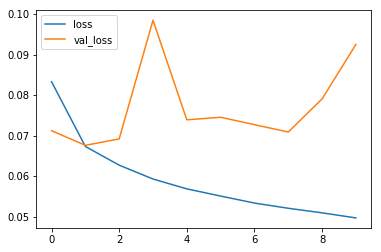

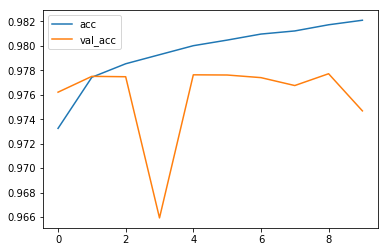

In [16]:
# plot loss data
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# plot accuracies  data
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [17]:
#prediction for a single sentence
input_sentence = "you are  looking very ugly fat girl"
sequence = t.texts_to_sequences([input_sentence])
padded_sequence = pad_sequences(sequence,maxlen=max_sequence_length)
prediction = model.predict([padded_sequence])
print(prediction)

[[9.3485779e-01 5.5959838e-04 1.2996584e-01 1.2103043e-05 4.4591290e-01
  8.6479320e-04]]


In [18]:
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']